In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

!pip install dask_cuda dask-cudf-cu12

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 535 (delta 174), reused 130 (delta 94), pack-reused 269 (from 1)
Receiving objects: 100% (535/535), 172.47 KiB | 939.00 KiB/s, done.
Resolving deltas: 100% (276/276), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.6 MB/s eta 0:00:00
Installing RAPIDS remaining 24.10.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import cudf
import cugraph as cg

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Networkx

Создадим простой граф при помощи networkx

In [4]:
G = nx.Graph()

добавим 1 ноду к графу

In [5]:
G.add_node(1)

In [6]:
G.nodes

NodeView((1,))

Можно также добавить несколько нод сразу

In [7]:
G.add_nodes_from([2, 3])
G.nodes

NodeView((1, 2, 3))

Добавим также связи между узлами

In [8]:
G.add_edges_from([(1, 2), (1, 3)])

In [9]:
G.edges

EdgeView([(1, 2), (1, 3)])

## cuGraph

Давайте повторим это все в cugraph

In [14]:
G_gpu = cg.Graph()

Добавить ноды к графу нельзя по одной, нужно через dataframe

In [15]:
edge_list = cudf.DataFrame({
    'source': [1, 2],
    'destination': [2, 3]
})

G_gpu = cg.Graph()
G_gpu.from_cudf_edgelist(edge_list, source='source', destination='destination')

In [16]:
G_gpu.nodes()

0    1
1    2
2    3
dtype: int64

Нюанс, ноды перезаписываются, так как считается, что мы передаем все необходимые ноды

Чтобы добавить что-то новое придется заново инициализировать граф

Можно через pandas, numpy, cudf, dask-cudf

In [17]:
edge_list = cudf.DataFrame({
    'source': [1, 1],
    'destination': [2, 3]
})

In [18]:
G_gpu = cg.Graph()
G_gpu.from_cudf_edgelist(edge_list, source='source', destination='destination')

In [19]:
G_gpu.nodes()

0    1
1    2
2    3
dtype: int64

In [20]:
G_gpu.edges()

,source,destination
0,1,2
1,1,3


Например, если захотим добавить что-то новое, то можно сделать так:

In [25]:
appended_values = cudf.DataFrame({
    'source': [2],
    'destination': [3]
})

edge_list = cudf.concat([edge_list, appended_values], ignore_index = True)

In [26]:
edge_list

,source,destination
0,1,2
1,1,3
2,2,3


In [27]:
G_gpu = cg.Graph()
G_gpu.from_cudf_edgelist(edge_list, source='source', destination='destination')
G_gpu.edges()

,source,destination
0,1,2
1,1,3
2,2,3


## Давайте загрузим известный датасет карате клуб и попробуем поанализировать его в разных фреймворках

## Networkx

https://raw.githubusercontent.com/rapidsai/notebooks/branch-0.8/cugraph/data/karate-data.csv

In [28]:
edges = pd.read_csv('karate-data.csv', sep='\t', names=['source', 'destination'])

In [29]:
edges

,source,destination
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
151,34,29
152,34,30
153,34,31
154,34,32


In [30]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges, source='source', target='destination')

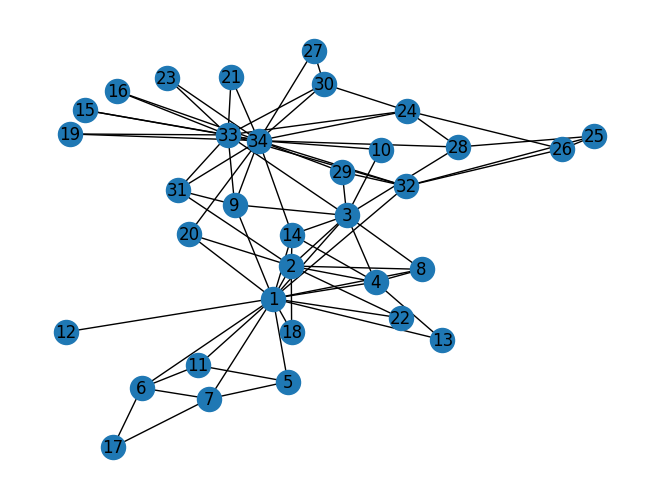

In [31]:
nx.draw(G, with_labels=True)

Давайте поисследуем сам граф

Средняя степень узлов сети и общие характеритики

In [32]:
def mean_nodes_degree(g):
    return 2 * len(g.edges) / len(g.nodes)

In [33]:
def get_statistics(g):
    print(f'Number of nodes = {len(g.nodes)}')
    print(f'Number of edges = {len(g.edges)}')

In [34]:
get_statistics(G)

Number of nodes = 34
Number of edges = 78


In [35]:
mean_nodes_degree(G)

4.588235294117647

In [36]:
G.degree

DegreeView({1: 16, 2: 9, 3: 10, 4: 6, 5: 3, 6: 4, 7: 4, 8: 4, 9: 5, 11: 3, 12: 1, 13: 2, 14: 5, 18: 2, 20: 3, 22: 2, 32: 6, 31: 4, 10: 2, 28: 4, 29: 3, 33: 12, 17: 2, 34: 17, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 5, 26: 3, 30: 4, 25: 3, 27: 2})

Каждый узел важен для сети по разному и для определения важности есть меры центральности. Мы рассмотрим центральность по степени и центральность по посредничеству

In [37]:
def get_centrality_by_degree(g):
    centrality = nx.algorithms.centrality.degree_centrality(g)
    return sorted(list(centrality.items()), key=lambda x: x[1], reverse=True)

In [38]:
get_centrality_by_degree(G)

[(34, 0.5151515151515151),
 (1, 0.48484848484848486),
 (33, 0.36363636363636365),
 (3, 0.30303030303030304),
 (2, 0.2727272727272727),
 (4, 0.18181818181818182),
 (32, 0.18181818181818182),
 (9, 0.15151515151515152),
 (14, 0.15151515151515152),
 (24, 0.15151515151515152),
 (6, 0.12121212121212122),
 (7, 0.12121212121212122),
 (8, 0.12121212121212122),
 (31, 0.12121212121212122),
 (28, 0.12121212121212122),
 (30, 0.12121212121212122),
 (5, 0.09090909090909091),
 (11, 0.09090909090909091),
 (20, 0.09090909090909091),
 (29, 0.09090909090909091),
 (26, 0.09090909090909091),
 (25, 0.09090909090909091),
 (13, 0.06060606060606061),
 (18, 0.06060606060606061),
 (22, 0.06060606060606061),
 (10, 0.06060606060606061),
 (17, 0.06060606060606061),
 (15, 0.06060606060606061),
 (16, 0.06060606060606061),
 (19, 0.06060606060606061),
 (21, 0.06060606060606061),
 (23, 0.06060606060606061),
 (27, 0.06060606060606061),
 (12, 0.030303030303030304)]

In [39]:
def get_centrality_by_betweenness(g):
    centrality = nx.algorithms.centrality.betweenness_centrality(g)
    return sorted(list(centrality.items()), key=lambda x: x[1], reverse=True)

In [40]:
get_centrality_by_betweenness(G)

[(1, 0.4376352813852815),
 (34, 0.30407497594997596),
 (33, 0.14524711399711404),
 (3, 0.14365680615680615),
 (32, 0.13827561327561327),
 (9, 0.05592682780182782),
 (2, 0.05393668831168831),
 (14, 0.045863395863395856),
 (20, 0.03247504810004811),
 (6, 0.02998737373737374),
 (7, 0.029987373737373736),
 (28, 0.022333453583453587),
 (24, 0.017613636363636363),
 (31, 0.014411976911976905),
 (4, 0.011909271284271283),
 (26, 0.0038404882154882162),
 (30, 0.0029220779220779218),
 (25, 0.0022095959595959595),
 (29, 0.0017947330447330447),
 (10, 0.0008477633477633478),
 (5, 0.0006313131313131313),
 (11, 0.0006313131313131313),
 (8, 0.0),
 (12, 0.0),
 (13, 0.0),
 (18, 0.0),
 (22, 0.0),
 (17, 0.0),
 (15, 0.0),
 (16, 0.0),
 (19, 0.0),
 (21, 0.0),
 (23, 0.0),
 (27, 0.0)]

PageRank

In [41]:
nx.pagerank(G,alpha=0.9)

{1: 0.09923208031303203,
 2: 0.05434031558257919,
 3: 0.059197046841871534,
 4: 0.03661246056285368,
 5: 0.02129205163493875,
 6: 0.028358863602879276,
 7: 0.028358863602879276,
 8: 0.02477713941194104,
 9: 0.030411546757834786,
 11: 0.02129205163493875,
 12: 0.00852322024354681,
 13: 0.01401516915803374,
 14: 0.030254309009995446,
 18: 0.013957441282540166,
 20: 0.01943461088059457,
 22: 0.013957441282540166,
 32: 0.03757266533528673,
 31: 0.024824588072166535,
 10: 0.01374609528355658,
 28: 0.02557998502294416,
 29: 0.019381731951150435,
 33: 0.07330616298815511,
 17: 0.015703158296594022,
 34: 0.10345460652842148,
 15: 0.013916466828162465,
 16: 0.013916466828162465,
 19: 0.013916466828162465,
 21: 0.013916466828162465,
 23: 0.013916466828162465,
 24: 0.03165330491466868,
 26: 0.02041070287756967,
 30: 0.026038055492344045,
 25: 0.020455327268852932,
 27: 0.014276670024478019}

Пора сделать аналогичное в cuGraph

## CuGraph

In [42]:
edges_gpu = cudf.read_csv('karate-data.csv', sep='\t', names=['source', 'destination'])

In [43]:
edges_gpu

,source,destination
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
151,34,29
152,34,30
153,34,31
154,34,32


In [44]:
G_gpu = cg.Graph()
G_gpu.from_cudf_edgelist(edges_gpu, source='source', destination='destination')

Посчитаем статистики, как и в networkx

In [45]:
def mean_nodes_degree(g):
    return 2 * len(g.edges()) / len(g.nodes())

In [46]:
def get_statistics(g):
    print(f'Number of nodes = {len(g.nodes())}')
    print(f'Number of edges = {len(g.edges())}')

In [47]:
get_statistics(G_gpu)

Number of nodes = 34
Number of edges = 78


In [48]:
mean_nodes_degree(G_gpu)

4.588235294117647

Надо быть внимательным, так как cugraph считает, что связь между нодами дает не 1 степень, а 2 (in и out)

In [49]:
G_gpu.degree()

,degree,vertex
0,34,34
1,32,1
2,24,33
3,20,3
4,18,2
5,12,4
6,12,32
7,10,9
8,10,14
9,10,24


Меры центральности

Центральность по степени не запрогали за нас, сделаем сами=)

In [50]:
def get_centrality_by_degree(g):
    centrality = g.degree()
    centrality['degree_centrality'] = centrality['degree'] / (len(g.nodes())-1) / 2
    centrality = centrality.sort_values(by='degree_centrality', ascending=False)
    return centrality

In [51]:
get_centrality_by_degree(G_gpu)

,degree,vertex,degree_centrality
0,34,34,0.515152
1,32,1,0.484848
2,24,33,0.363636
3,20,3,0.303030
4,18,2,0.272727
5,12,4,0.181818
6,12,32,0.181818
7,10,9,0.151515
8,10,14,0.151515
9,10,24,0.151515


In [52]:
def get_centrality_by_betweenness(g):
    centrality = cg.centrality.betweenness_centrality(g)
    centrality = centrality.sort_values(by='betweenness_centrality', ascending=False)
    return centrality

In [53]:
get_centrality_by_betweenness(G_gpu)

,vertex,betweenness_centrality
1,1,0.437635
0,34,0.304075
2,33,0.145247
3,3,0.143657
6,32,0.138276
7,9,0.055927
4,2,0.053937
8,14,0.045863
18,20,0.032475
10,6,0.029987


PageRank

In [54]:
cg.link_analysis.pagerank(G_gpu)

/usr/local/lib/python3.10/dist-packages/cugraph/link_analysis/pagerank.py:227: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


,vertex,pagerank
0,34,0.100917
1,1,0.096999
2,33,0.071692
3,3,0.057078
4,2,0.052877
5,4,0.035860
6,32,0.037158
7,9,0.029766
8,14,0.029537
9,24,0.031522


Много чего нет в cuGraph, но есть и преимущества)
Например, в Networkx не реализованы алгоритмы кластеризации (их мало), а многие из существующих есть в cuGraph

Метод louvain на основе меры модулярности

In [55]:
def louvain_clusters(g):
    result = cg.community.louvain(g)
    modularity = result[1]
    clusters = result[0]
    return modularity, clusters

In [56]:
modularity, clusters = louvain_clusters(G_gpu)

In [57]:
modularity

0.4155982732772827

In [58]:
clusters = clusters.to_pandas()
clusters = clusters.sort_values(by='vertex')

In [59]:
clusters = pd.DataFrame(G.nodes).merge(clusters, left_on=0, right_on='vertex')

Отрисуем граф при помощи Networkx

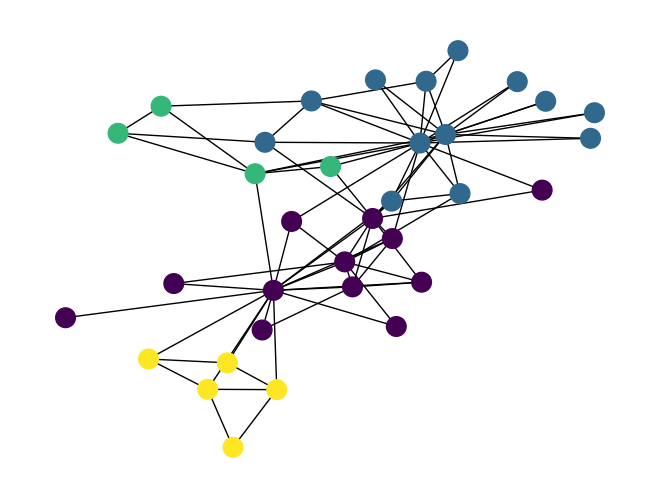

In [60]:
nx.draw(G,node_color=clusters['partition'],node_size=200)

Ниже представлен алгоритм Гирвана-Ньюмена по поиску сообществ. Его идея:

    1) Находим такое ребро, через которое проходит наибольшее количество кратчайших путей
    2) Удаляем данное ребро из графа
    3) После удаления ребра проверяем, не появились ли у нас изолированные сообщества
    4) Повторяем алгоритм до получения нужного количества сообществ

# Girvan-Newman (NetworkX)

In [67]:
def most_central_edge(G):
    centrality = nx.algorithms.centrality.edge_betweenness_centrality(G)
    return max(centrality, key=centrality.get)

In [68]:
def get_n_cluster(G, n_clusters):
    G_new = G.copy()
    while len(list(nx.connected_components(G_new))) < n_clusters:
        edge_to_remove = most_central_edge(G_new)
        G_new.remove_edge(edge_to_remove[0], edge_to_remove[1])
    return list(nx.connected_components(G_new))

In [69]:
def get_color_map(G, connected_components):
    b = {}
    for i, values in enumerate(connected_components):
        for value in values:
            b[value] = i
    color_map = []
    for node in G.nodes():
        color_map.append(b[node])
    return color_map

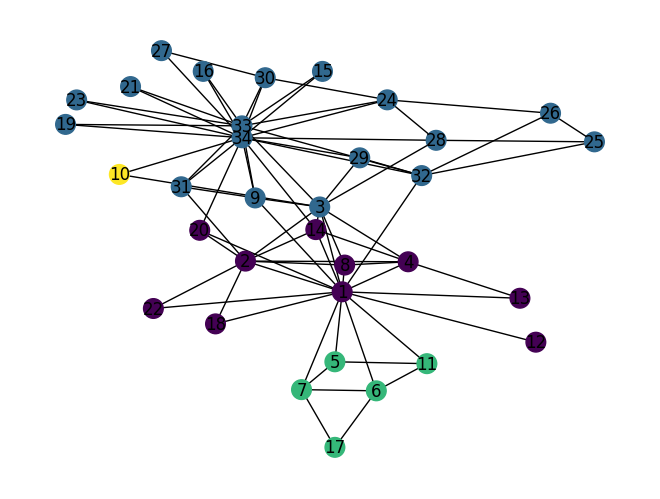

In [70]:
clusters = get_n_cluster(G, 4)
nx.draw(G,node_size=200, with_labels=True, node_color=get_color_map(G, clusters))

# Домашнее задание

В NetworkX есть алгоритм определения центральности через собственные вектора nx.algorithms.centrality.eigenvector_centrality(G). Сейчас мы рассмотрим реализацию данного алгоритма.
Заданием будет следующее:

    1) Переписать реализацию под GPU (cupy, numba, cudf, cugraph...)
    2) Для графа карате клуба вычислить degree centrality, betweenness centrality, eigenvector centrality и pagerank.
    3) Сравнить 4 характеристики между собой, на сколько они похожи \ отличаются и в чем

In [71]:
nx.algorithms.centrality.eigenvector_centrality(G)

{1: 0.35548349418519426,
 2: 0.26595387045450236,
 3: 0.3171893899684447,
 4: 0.21117407832057056,
 5: 0.0759664588165738,
 6: 0.07948057788594245,
 7: 0.07948057788594245,
 8: 0.1709551149803543,
 9: 0.22740509147166046,
 11: 0.0759664588165738,
 12: 0.05285416945233646,
 13: 0.08425192086558085,
 14: 0.22646969838808148,
 18: 0.0923967566684595,
 20: 0.14791134007618667,
 22: 0.0923967566684595,
 32: 0.19103626979791702,
 31: 0.17476027834493088,
 10: 0.10267519030637758,
 28: 0.13347932684333308,
 29: 0.13107925627221215,
 33: 0.3086510477336959,
 17: 0.02363479426059687,
 34: 0.37337121301323495,
 15: 0.10140627846270833,
 16: 0.10140627846270833,
 19: 0.10140627846270833,
 21: 0.10140627846270833,
 23: 0.10140627846270833,
 24: 0.15012328691726787,
 26: 0.05920820250279008,
 30: 0.13496528673866567,
 25: 0.057053735638028055,
 27: 0.07558192219009326}

In [96]:
M = nx.to_numpy_array(G)
eigenvalue, eigenvector = np.linalg.eig(M)
largest = np.array(eigenvector[:, 0].flatten().real)
norm = np.sign(largest.sum()) * np.linalg.norm(largest)
eigen = largest / norm


In [98]:
import numpy as np
def eigen_centrality(G):
    #переведем в матрицу numpy
    M = nx.to_numpy_array(G)
    #получим собственные вектора и собственные значения
    eigenvalue, eigenvector = np.linalg.eig(M)
    #берем вектор, соответсвующий наибольшему собственному значению
    largest = np.array(eigenvector[:, 0].flatten().real)
    #нормируем
    norm = np.sign(largest.sum()) * np.linalg.norm(largest)
    eigen = largest / norm
    return dict(zip(G, eigen))

In [99]:
eigen_centrality(G)

{1: 0.355491444524567,
 2: 0.26595991955249243,
 3: 0.31719250448643166,
 4: 0.21117972037789023,
 5: 0.075968818183069,
 6: 0.07948304511709949,
 7: 0.07948304511709949,
 8: 0.17095974804479627,
 9: 0.22740390712540007,
 11: 0.07596881818306894,
 12: 0.05285569749352141,
 13: 0.08425462871671373,
 14: 0.2264727201424812,
 18: 0.09239953819570265,
 20: 0.14791251029338756,
 22: 0.09239953819570265,
 32: 0.1910338414065437,
 31: 0.17475830231435285,
 10: 0.10267425072358635,
 28: 0.13347715338024002,
 29: 0.13107782298371043,
 33: 0.30864421979104734,
 17: 0.023635628104591376,
 34: 0.3733634702914828,
 15: 0.10140326218952443,
 16: 0.10140326218952443,
 19: 0.10140326218952443,
 21: 0.10140326218952443,
 23: 0.10140326218952443,
 24: 0.15011857186115274,
 26: 0.059206474916778565,
 30: 0.13496081926232797,
 25: 0.0570524405411657,
 27: 0.07557941348827213}

Немного помощи с ДЗ

In [100]:
#если не добавить веса, то будет все ломаться
edges_gpu['weights'] = 1

In [102]:
G_gpu = cg.Graph()
G_gpu.from_cudf_edgelist(edges_gpu, source='source', destination='destination', edge_attr='weights')

P.S. будьте внимательны с тем, где находится наибольшее собственное значение